In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import random
import tempfile
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from keras import backend as K

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
path='drive/MyDrive/Capstone(Team10)/code'


file = tf.keras.utils

with open(path+'/data/X_data_full.pkl','rb') as f:
  X_data=pickle.load(f)

raw_df = pd.read_csv(path+'/data/rawdata_USA.csv', index_col=0, parse_dates=True)
raw_df.index.name='date'

metadata=pd.read_csv(path+'/data/metadata_final.csv')

X_data.head(5)

Mounted at /content/drive


,103SPREAD,BSEMFT02,IR3TED01,BSOITE02,BSCICP02,CSCICP02,IRSTFR01,IRLTLT01,IR3TCD01,BSPRTE02,...,PIEAMP01,LFACTTTT,LFEMTTTT,LFHUTTTT,LFUNTTTT,CPGRLE01,CPGREN01,W875RX1,SP500,WTI
date,,,,,,,,,,,,,,,,,,,,,
1973-01-01,1.05,10.524009,0.72,6.348940,3.2,-3.156101,0.61,0.10,0.38,2.569360,...,0.011669,-0.005199,-0.002870,-0.048944,-0.048944,0.000000,0.010772,-0.005338,-0.017259,0.0
1973-02-01,1.04,-9.300966,1.81,-10.047100,-5.0,-1.757375,0.64,0.18,0.53,-6.665425,...,0.013825,0.009974,0.008990,0.028710,0.028710,0.004474,0.010657,0.003819,-0.038211,0.0
1973-03-01,0.62,1.166287,0.25,2.126248,0.0,-1.757375,0.51,0.07,0.71,0.992926,...,0.015891,0.005440,0.006415,-0.013113,-0.013113,0.004454,0.003527,0.000421,-0.001434,0.0
1973-04-01,0.41,-0.916898,-0.44,-5.200446,-3.8,-1.757375,0.03,-0.04,0.26,-3.104780,...,0.006734,0.001934,0.001266,0.014685,0.014685,0.002220,0.010508,0.003011,-0.041656,0.0
1973-05-01,0.49,-4.282950,0.38,-4.494776,-5.8,-1.793239,0.72,0.18,0.24,-13.030239,...,0.006689,-0.000461,0.001052,-0.029588,-0.029588,0.004425,0.006944,0.003652,-0.019064,0.0


In [9]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []

    if type(Xs)==pd.core.frame.DataFrame:
      for i in range(len(X) - time_steps):
          v = X.iloc[i:(i + time_steps)].values
          Xs.append(v)
          ys.append(y.iloc[i + time_steps].values)
          Xs=np.array(Xs)
          ys=np.array(ys)

    else:
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])

    return np.array(Xs), np.array(ys)

In [10]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]


In [11]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')

## make index for train, validation dataset

def make_split(X_data, n_splits, test_year):
  train_idxs=[]
  val_idxs=[]

  tss=BlockingTimeSeriesSplit(n_splits=n_splits)

  for train_idx, val_idx in tss.split(X_data[:-(test_year*12)]):
    train_idxs.append(train_idx)
    val_idxs.append(val_idx)

  return train_idxs, val_idxs

def plot_cv_indices(cv, X, n_splits, lw=10):

    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

In [12]:
def make_lstm_model(num_layer, X_train, nc, metrics, loss_type, dropout, activation, regularizer):
    model = Sequential()
    model.add(LSTM(num_layer, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=dropout, activation=activation, kernel_regularizer=regularizer))  ##input_shape=(X_train.shape[1], X_train.shape[2])
    model.add(Dense(nc, activation='softmax'))
    model.compile(loss=loss_type, optimizer='adam', metrics=metrics)  ##['AUC','Accuracy','Recall','Precision','F1Score']
    return model

def make_gru_model(num_layer, X_train, nc, metrics, loss_type, dropout, activation, regularizer):
    model = Sequential()
    model.add(GRU(num_layer, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=dropout, activation=activation, kernel_regularizer=regularizer))  ##input_shape=(X_train.shape[1], X_train.shape[2])
    model.add(Dense(nc, activation='softmax'))
    model.compile(loss=loss_type, optimizer='adam', metrics=metrics)  ##['AUC','Accuracy','Recall','Precision','F1Score']
    return model

In [3]:
threshold=50
test_year=5
n_splits=3

tss=BlockingTimeSeriesSplit(n_splits=n_splits)
plot_cv_indices(tss, X_data[:-(test_year*12)], n_splits=n_splits)

## make index for train, validation dataset
train_idxs=[]
val_idxs=[]

for train_idx, val_idx in tss.split(X_data[:-(test_year*12)]):
  train_idxs.append(train_idx)
  val_idxs.append(val_idx)

## checking if validation dataset in each block contains at least one recession period.

for ytype in ['y_oecd','y_nber','y_agg']:
  y=raw_df[ytype]
  y_data=y[-(threshold*12+6):-6]

  print(ytype)

  for i, idx in enumerate(train_idxs):
    n_pos=y_data[idx].value_counts()[1]
    print('positive class 1 in {} training:'.format(i), n_pos)
    if ytype=='y_agg':
      n_pos2=y_data[idx].value_counts()[2]
      print('positive class 2 in {} training:'.format(i), n_pos2)

  for i, idx in enumerate(val_idxs):
    if 1 not in (y_data[idx].value_counts()).keys():
      n_pos=0
    elif 2 not in (y_data[idx].value_counts()).keys():
      n_pos=y_data[idx].value_counts()[1]
      n_pos2=0
    else:
      n_pos2=y_data[idx].value_counts()[2]

    print('positive class 1 in {} validation:'.format(i), n_pos)
    if ytype=='y_agg':
      print('positive class 2 in {} validation:'.format(i), n_pos2)

NameError: ignored

In [11]:
######################run this cell only for training whole models####################################
np.random.seed(699)

os.environ['PYTHONHASHSEED'] = '699'
random.seed(699)

# Also set the tf randomness to some fixed values like this if you need:
tf.compat.v1.set_random_seed(699)
tf.keras.utils.set_random_seed(699)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

def grid_search(path, X_data, y_data, model_type, y_type, n_splits, test_year, nl=[30, 50, 70, 100],
                epochs=[100], batch_sizes=[12], time_steps=[12, 18, 24], es=True, dropouts=[0.2],
                activation='tanh', reg_methods=[None, 'L1'], reg_factors=[0.01, 0.03]):

  results = []
  history_dict={'model':[], 'val':[], 'history':[],
                'auc': [], 'acc': [], 'recall': [],'precision': [],
                'recall_0': [], \
                'recall_1': [], \
                'recall_2': [], \
                'final_auc':[], \
                'final_acc':[], \
                'final_recall':[], \
                'final_precision':[],
                'final_recall_0':[],
                'final_recall_1':[],
                'final_recall_2':[],}

# ##########tmp###############################(and comment out above history_dict part)
#   with open(path+'/history_dict.pkl','rb') as f:
#     history_dict=pickle.load(f)

  best_auc = 0
  best_params = None
  nc=len(y_data.unique())

  train_idxs, val_idxs = make_split(X_data, n_splits, test_year)

  for time_step in time_steps:
    loss_type = 'categorical_crossentropy'   ##if y_type == 'y_agg' else 'binary_crossentropy'
    for num_epochs in epochs:
      for batch_size in batch_sizes:
        for num_layer in nl:
          for dropout in dropouts:
            for method in reg_methods:
              for factor in reg_factors:

                if method=='L1':
                  reg=regularizers.L1(factor)
                elif method=='L2':
                  reg=regularizers.L2(factor)
                else:
                  reg=None

                if method==None:
                  model_name='clf_{}_{}_{}_b{}_ep{}_h{}_d{}_{}'.format(y_type, model_type, time_step, batch_size, num_epochs, num_layer, dropout, method)
                else:
                  model_name='clf_{}_{}_{}_b{}_ep{}_h{}_d{}_{}_{}'.format(y_type, model_type, time_step, batch_size, num_epochs, num_layer, dropout, method, factor)


                for i, (train_idx, val_idx) in enumerate(zip(train_idxs, val_idxs)):

                  X_train=X_data.iloc[list(train_idx)]
                  y_train=y_data.iloc[list(train_idx)]
                  X_val=X_data.iloc[list(val_idx)]
                  y_val=y_data.iloc[list(val_idx)]

                  ##standard scaling
                  scaler = StandardScaler()
                  X_train = scaler.fit_transform(X_train)
                  X_val = scaler.transform(X_val)

                  ##make timestep
                  trainx, trainy = create_dataset(X_train, y_train, time_step) ##(X_train, y_train, time_step)
                  valx, valy = create_dataset(X_val, y_val, time_step)   ##(X_val, y_val, time_step)
                  trainy = to_categorical(trainy, num_classes=nc)
                  valy = to_categorical(valy, num_classes=nc)

                  ##assign class weight(more weight for less frequent class)
                  if y_type!='y_agg':

                    metrics=['AUC','Accuracy','Recall','Precision',
                            Recall(class_id=0, name='recall_0'),
                            Recall(class_id=1, name='recall_1')]

                  else:

                    metrics=['AUC','Accuracy','Recall','Precision',
                            Recall(class_id=0, name='recall_0'),
                            Recall(class_id=1, name='recall_1'),
                            Recall(class_id=2, name='recall_2')]



                  # create the model weighted more for class 1
                  if model_type=='lstm':
                    model=make_lstm_model(num_layer, trainx, nc, metrics, loss_type, dropout, activation=activation, regularizer=reg)
                  else:
                    model=make_gru_model(num_layer, trainx, nc, metrics, loss_type, dropout, activation=activation, regularizer=reg)

                  # assian early stopping and use best weight
                  if es==True:
                    early_stop = EarlyStopping(monitor='recall_1', patience=5, verbose=1,
                                              restore_best_weights=True)   ##restore best_weight=True
                    history=model.fit(trainx, trainy, epochs=num_epochs, batch_size=batch_size, callbacks=[early_stop])
                  else:
                    history=model.fit(trainx, trainy, epochs=num_epochs, batch_size=batch_size)

                  # Final evaluation of the model
                  scores = model.evaluate(valx, valy, verbose=0)

#                  print(valx, valy, scores)

                  history_dict['model'].append(model_name)
                  history_dict['val'].append(i)
                  history_dict['history'].append(history)
                  history_dict['auc'].append(scores[1])
                  history_dict['acc'].append(scores[2])
                  history_dict['recall'].append(scores[3])
                  history_dict['precision'].append(scores[4])
                  history_dict['recall_0'].append(scores[5])
                  history_dict['recall_1'].append(scores[6])

                  if y_type=='y_agg':
                    history_dict['recall_2'].append(scores[7])
                  else:
                    history_dict['recall_2'].append(-100)

                X_test=X_data.iloc[-test_year*12:]
                y_test=y_data.iloc[-test_year*12:]

                X_ft=X_data.iloc[:-test_year*12]
                y_ft=y_data.iloc[:-test_year*12]

                ##standard scaling
                scaler = StandardScaler()
                X_ft = scaler.fit_transform(X_ft)
                X_test = scaler.transform(X_test)

                ft_x, ft_y = create_dataset(X_ft, y_ft, time_step) ##(X_test, y_test, time_step)
                testx, testy = create_dataset(X_test, y_test, time_step) ##(X_test, y_test, time_step)
                ft_y = to_categorical(ft_y, num_classes=nc)
                testy = to_categorical(testy, num_classes=nc)

                ##assign class weight(more weight for less frequent class)
                if y_type!='y_agg':
                  metrics=['AUC','Accuracy','Recall','Precision',
                          Recall(class_id=0, name='recall_0'),
                          Recall(class_id=1, name='recall_1')]

                else:
                  metrics=['AUC','Accuracy','Recall','Precision',
                          Recall(class_id=0, name='recall_0'),
                          Recall(class_id=1, neame='recall_1'),
                          Recall(class_id=2, name='recall_2')]

                # create the model weighted more for class 1
                if model_type=='lstm':
                  model=make_lstm_model(num_layer, ft_x, nc, metrics, loss_type, dropout, activation=activation, regularizer=reg)
                else:
                  model=make_gru_model(num_layer, ft_x, nc, metrics, loss_type, dropout, activation=activation, regularizer=reg)


                if es==True:
                  early_stop = EarlyStopping(monitor='recall_1', patience=5, verbose=1,
                                            restore_best_weights=True)   ##restore best_weight=True
                  history=model.fit(ft_x, ft_y, epochs=num_epochs, batch_size=batch_size, callbacks=[early_stop])
                else:
                  history=model.fit(ft_x, ft_y, epochs=num_epochs, batch_size=batch_size)


                final_scores=model.evaluate(testx, testy, verbose=0)  ##test...?


                # y_pred_prob=model.predict(testx)
                # y_pred=model.predict(testx).argmax(axis=1)
                # y_test=testy.argmax(axis=1)
                # cf_matrix = confusion_matrix(y_test, y_pred)
                # print(cf_matrix)
                # print(classification_report(y_test, y_pred))

                history_dict['final_auc'].extend([final_scores[1]]*n_splits)
                history_dict['final_acc'].extend([final_scores[2]]*n_splits)
                history_dict['final_recall'].extend([final_scores[3]]*n_splits)
                history_dict['final_precision'].extend([final_scores[4]]*n_splits)
                history_dict['final_recall_0'].extend([final_scores[5]]*n_splits)
                history_dict['final_recall_1'].extend([final_scores[6]]*n_splits)
                if y_type=='y_agg':
                  history_dict['final_recall_2'].extend([final_scores[7]]*n_splits)
                else:
                  history_dict['final_recall_2'].extend([-100]*n_splits)

                with open(path+'/history_dict.pkl','wb') as f:
                  pickle.dump(history_dict, f)

                model.save(path+'/{}.h5'.format(model_name))




In [12]:
######################run this cell only for training whole models####################################
ytype_list=['oecd']   #'oecd','oecd','oecd','oecd','nber','nber','nber','nber','agg','agg','agg','agg']
modeltype_list=['gru'] #'lstm','lstm','gru','gru','lstm','lstm','gru','gru','lstm','lstm','gru','gru']
es_list=[False]   #True, False, True, False, True, False, True, False, True, False, True, False]

cases=list(zip(ytype_list, modeltype_list, es_list))

for (ytype, model_type, es) in cases:

  np.random.seed(699)
  os.environ['PYTHONHASHSEED'] = '699'
  random.seed(699)
  # Also set the tf randomness to some fixed values like this if you need:
  tf.compat.v1.set_random_seed(699)
  tf.keras.utils.set_random_seed(699)

  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)

  threshold=50

  y_type='y_{}'.format(ytype)
  n_splits=3
  test_year=5

  y=raw_df[y_type]
  y_data=y[-(threshold*12+6):-6]

  if es==True:
    folder_path=path+'/model_final/change_test{}_{}_{}_es'.format(test_year, ytype, model_type)
  else:
    folder_path=path+'/model_final/change_test{}_{}_{}'.format(test_year, ytype, model_type)

  if not os.path.exists(folder_path):
    os.mkdir(folder_path)

  grid_search(folder_path, X_data, y_data, model_type, y_type, n_splits, test_year, nl=[30, 50, 70, 100], ##
              epochs=[100], batch_sizes=[12], time_steps=[12, 18, 24], es=es, dropouts=[0.2],   ##
              activation='tanh', reg_methods=[None, 'L1'], reg_factors=[0.01, 0.03])

#path=folder_path
# nl=[30]
# epochs=[100]
# batch_sizes=[12]
# time_steps=[6, 9, 12, 18, 24]
# dropouts=[0.2]
# activation='tanh'
# reg_methods=['L1']
# reg_factors=[0.03]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
43/43 [==============================] - 4s 20ms/step - loss: 0.5518 - auc: 0.7842 - Accuracy: 0.7093 - recall: 0.7093 - precision: 0.7093 - recall_0: 0.8396 - recall_1: 0.5381
Epoch 2/100
43/43 [==============================] - 1s 18ms/step - loss: 0.3836 - auc: 0.9130 - Accuracy: 0.8566 - recall: 0.8566 - precision: 0.8566 - recall_0: 0.9283 - recall_1: 0.7623
Epoch 3/100
43/43 [==============================] - 1s 19ms/step - loss: 0.2547 - auc: 0.9643 - Accuracy: 0.9070 - recall: 0.9070 - precision: 0.9070 - recall_0: 0.9181 - recall_1: 0.8924
Epoch 4/100
43/43 [==============================] - 1s 16ms/step - loss: 0.1791 - auc: 0.9805 - Accuracy: 0.9419 - recall: 0.9419 - precision: 0.9419 - recall_0: 0.9522 - recall_1: 0.9283
Epoch 5/100
43/43 [==============================] - 1s 16ms/step - loss: 0.1195 - auc: 0.9929 - Accuracy: 0.9593 - recall: 0.9593 - precision: 0.9593 - recall_0: 0.9659 - recall_1: 0.9507
Epoch 6/100
43/43 [============

In [4]:
folders=[x for x in os.listdir(path+"/model_final") if ('change' in x)]  ##&('ls' not in x)

for i, folder in enumerate(folders):
  folder_path=path+'/model_final/{}'.format(folder)
  with open(folder_path+'/history_dict.pkl','rb') as f:
    history_dict=pickle.load(f)

  ytype=folder.split("_")[2]
  model_type=folder.split("_")[3]
  if folder.split("_")[-1]=='es':
    es=True
  else:
    es=False

  df_tmp=pd.DataFrame(history_dict)
  df_tmp['ytype']=ytype
  df_tmp['model_type']=model_type
  df_tmp['early_stopping']=es

  if i==0:
    df_result=df_tmp
  else:
    df_result=pd.concat([df_result, df_tmp])

## model selection: according to cross validation recall, auc scores
df_selection=df_result.groupby(['model','early_stopping']).mean().sort_values(['recall','auc'], ascending=[False, False])

with open(path+'/model_final/df_selection.pkl', 'wb') as f:
  pickle.dump(df_selection, f)

df_selection.head(20)

with open(path+'/model_final/df_selection.pkl', 'wb') as f:
  pickle.dump(df_selection, f)

<ipython-input-4-77cdfadf0ca6>:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_selection=df_result.groupby(['model','early_stopping']).mean().sort_values(['recall','auc'], ascending=[False, False])


In [5]:
with open(path+'/model_final/df_selection.pkl', 'rb') as f:
  df_selection = pickle.load(f)

model_name=df_selection.iloc[0].name[0]
es=df_selection.iloc[0].name[1]
print(model_name, es)  ## best model=clf_y_oecd_gru_24_b12_ep100_h30_d0.2_None /  es=True

clf_y_oecd_gru_24_b12_ep100_h30_d0.2_None True


In [6]:
nb_path = '/content/notebooks'
sys.path.insert(0,nb_path)
!pip install shap

tf.compat.v1.disable_v2_behavior()  ## input type err solved
from tensorflow.keras.models import load_model
import shap
from sklearn.metrics import confusion_matrix,classification_report

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 8.3 MB/s eta 0:00:00


Instructions for updating:
non-resource variables are not supported in the long term
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [7]:
ytype= model_name.split('_')[2]  # options: nber, oecd, or agg
model_type=model_name.split('_')[3]  # options: lstm, gru

if es==True:
  folder_path=path+'/model_final/change_test{}_{}_{}_es'.format(test_year, ytype, model_type)
else:
  folder_path=path+'/model_final/change_test{}_{}_{}'.format(test_year, ytype, model_type)

with open(path+'/data/X_data_full.pkl','rb') as f:
  X_data=pickle.load(f)

y_type='y_{}'.format(ytype)
n_splits=3
test_year=5

y=raw_df[y_type]
y_data=y[-(threshold*12+6):-6]

time_step=int(model_name.split('_')[4])
batch_size=int(model_name.split('_')[5][1:])
num_epochs=int(model_name.split('_')[6][2:])
num_layer=int(model_name.split('_')[7][1:])
dropout=float(model_name.split('_')[8][1:])
method=model_name.split('_')[9]

if method!='None':
  reg_factor=float(model_name.split('_')[10])
else:
  reg_factor=0

if y_type=='y_agg':
    num_classes=3
else:
    num_classes=2

In [13]:
# Also set the tf randomness to some fixed values like this if you need:
np.random.seed(699)
os.environ['PYTHONHASHSEED'] = '699'
random.seed(699)
tf.compat.v1.set_random_seed(699)
tf.keras.utils.set_random_seed(699)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


## whole train dataset
X_train=X_data.iloc[:-test_year*12]
y_train=y_data.iloc[:-test_year*12]
X_test=X_data.iloc[-test_year*12-time_step:]
y_test=y_data.iloc[-test_year*12-time_step:]

## standard scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## make timestep
trainx, trainy = create_dataset(X_train, y_train, time_step)
testx, testy = create_dataset(X_test, y_test, time_step)
trainy = to_categorical(trainy, num_classes=num_classes)
testy = to_categorical(testy, num_classes=num_classes)

## calculate class weight
if y_type!='y_agg':
  metrics=['AUC','Accuracy','Recall','Precision',
           Recall(class_id=0, name='recall_0'),
           Recall(class_id=1, name='recall_1')]

else:
  metrics=['AUC','Accuracy','Recall','Precision',
           Recall(class_id=0, name='recall_0'),
           Recall(class_id=1, name='recall_1'),
           Recall(class_id=2, name='recall_2')]

final_model=load_model(folder_path+'/{}.h5'.format(model_name), compile=False)
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

if es==True:
  early_stop = EarlyStopping(monitor='recall_1', patience=5, verbose=1,restore_best_weights=True)
  history=final_model.fit(trainx, trainy, epochs=num_epochs, batch_size=batch_size, callbacks=[early_stop])
else:
  history=final_model.fit(trainx, trainy, epochs=num_epochs, batch_size=batch_size)

Train on 516 samples
Epoch 1/100
516/516 [==============================] - 1s 2ms/sample - loss: 0.4906 - auc: 0.8466 - accuracy: 0.0000e+00 - recall: 0.7578 - precision: 0.7578 - recall_0: 0.8771 - recall_1: 0.6009
Epoch 2/100
516/516 [==============================] - 0s 690us/sample - loss: 0.4187 - auc: 0.8944 - accuracy: 0.0000e+00 - recall: 0.8140 - precision: 0.8140 - recall_0: 0.8908 - recall_1: 0.7130
Epoch 3/100
516/516 [==============================] - 0s 665us/sample - loss: 0.3548 - auc: 0.9268 - accuracy: 0.0000e+00 - recall: 0.8643 - precision: 0.8643 - recall_0: 0.9078 - recall_1: 0.8072
Epoch 4/100
516/516 [==============================] - 0s 713us/sample - loss: 0.2767 - auc: 0.9547 - accuracy: 0.0000e+00 - recall: 0.9070 - precision: 0.9070 - recall_0: 0.9522 - recall_1: 0.8475
Epoch 5/100
516/516 [==============================] - 0s 661us/sample - loss: 0.2389 - auc: 0.9679 - accuracy: 0.0000e+00 - recall: 0.9089 - precision: 0.9089 - recall_0: 0.9181 - recall_1

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


              precision    recall  f1-score   support

           0       1.00      0.73      0.85        56
           1       0.21      1.00      0.35         4

    accuracy                           0.75        60
   macro avg       0.61      0.87      0.60        60
weighted avg       0.95      0.75      0.81        60

[0.5782241841157277, 0.7708333, 0.0, 0.75, 0.75, 0.73214287, 1.0]


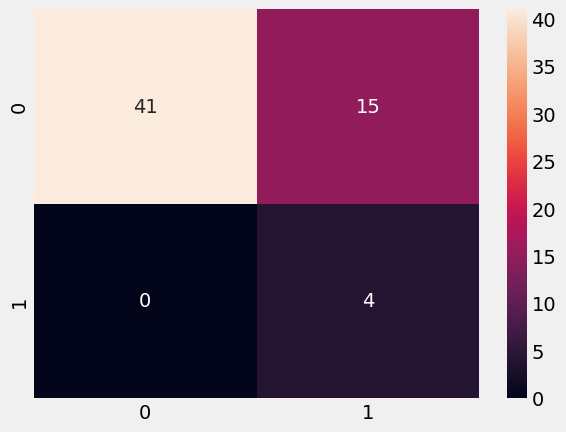

In [14]:
scores=final_model.evaluate(testx, testy, verbose=0)
y_pred_prob=final_model.predict(testx)
y_pred=final_model.predict(testx).argmax(axis=1)
y_test=testy.argmax(axis=1)

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)

# Showing percentage of data represented in each quadrant
# sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
#             fmt='.2%', cmap='Blues')

print(classification_report(y_test, y_pred))
print(scores)

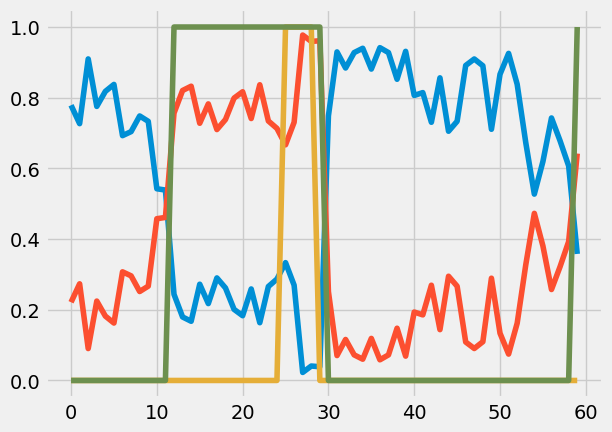

In [15]:
plt.plot(y_pred_prob)
plt.plot(y_test)
plt.plot(y_pred)

In [16]:
## generate shap explainer and calculate shap values
explainer=shap.DeepExplainer(final_model, trainx)
values_test=explainer.shap_values(np.array(testx))
values_train=explainer.shap_values(np.array(trainx))

selected_features=list(X_data.columns)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



In [17]:
values_train[0].shape,values_train[1].shape, len(values_train)

((516, 24, 45), (516, 24, 45), 2)

['10YT-3MTBILL',
 'Interest Rates Long-term government bond yields 10-year Main (including benchmark)',
 'Real personal income excluding current transfer receipts',
 'Business tendency surveys (manufacturing) Employment Future Tendency National indicator',
 'Labour Force Survey - quarterly levels Employed population Aged 15 and over All persons']

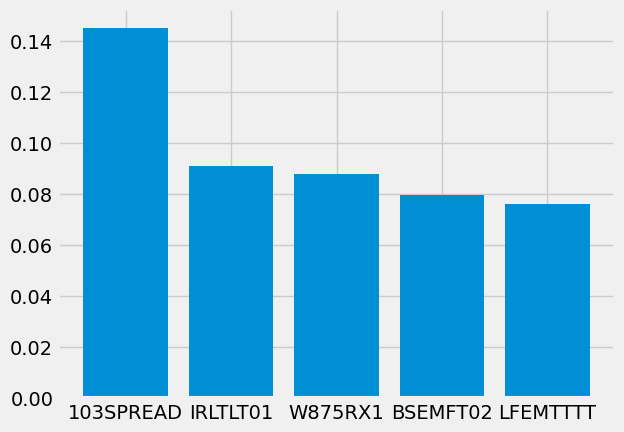

In [18]:
## feature importance
## ****** assign label here! ***********//
label=1
version='train' ## 'train' or 'test'
##############################################################

if version=='train':
    values=values_train
    x=trainx
else:
    values=values_test
    x=testx

ft_imp=abs(np.sum(values, axis=2)[label]).mean(0)
df=pd.DataFrame({'feature':selected_features, 'ft_imp':ft_imp}).sort_values('ft_imp', ascending=False)[:5]
plt.bar(df.feature, df.ft_imp)
[metadata[metadata.SUBJECT==x]['Name'].values[0] for x in df.feature]


##['Interest Rates Long-term government bond yields 10-year Main (including benchmark)',
#  'Monetary aggregates and their components Broad money and components M3 M3',
#  'Labour Force Survey - quarterly levels Employed population Aged 15 and over All persons',
#  'Consumer Price Index OECD Groups All items non-food non-energy Total',
#  'Real personal income excluding current transfer receipts']

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


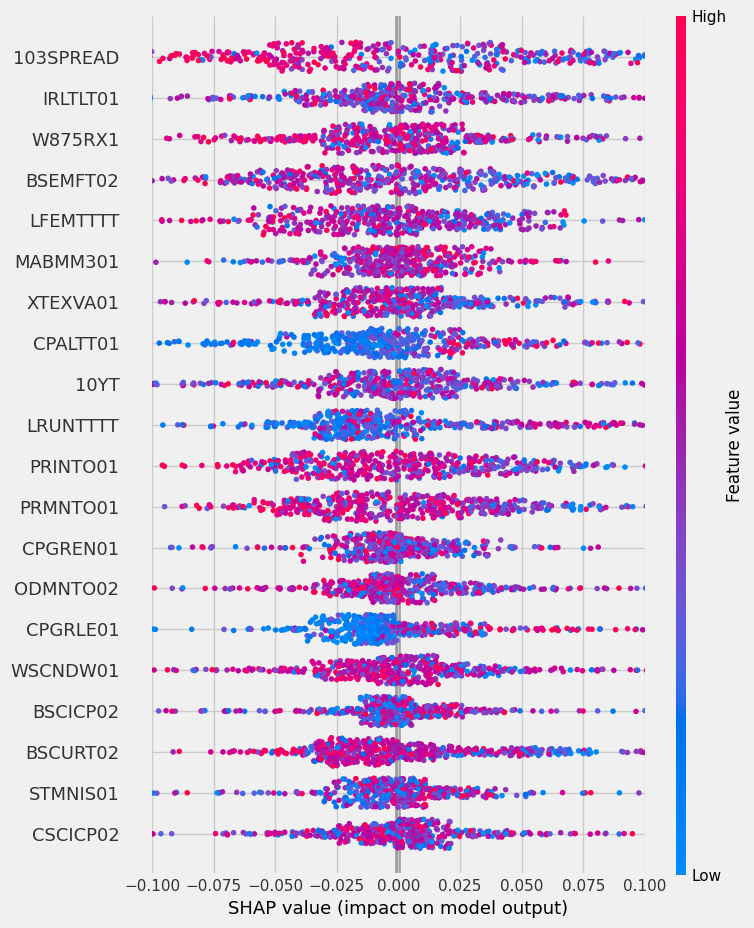

In [19]:
## ****** assign here! ***********//
label=1
version='train' ## 'train' or 'test'
##############################################################

if version=='train':
    values=values_train
    x=trainx
else:
    values=values_test
    x=testx

## reduce dimension of (sample * timestep * features) ==> (sample * features)
## for shap_values, sum across timesteps
## for feature value, average across timesteps
shap.summary_plot(np.sum(values, axis=2)[label], np.mean(x, axis=1), selected_features, show=False)
ax = plt.gca()
# You can change the min and max value of xaxis by changing the arguments of:
ax.set_xlim(-0.1, 0.1)
plt.show()

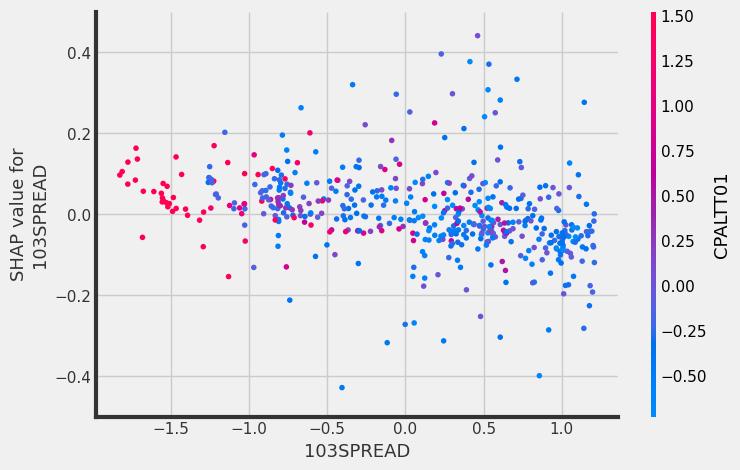

In [20]:
## ****** assign here! ***********//
label=1
variable='103SPREAD'
version='train' ## 'train' or 'test'
##############################################################

var_idx=selected_features.index(variable)

if version=='train':
    values=values_train
    x=trainx
else:
    values=values_test
    x=testx

## reduce dimension of (sample * timestep * features) ==> (sample * features)
## for shap_values, sum across timesteps
## for feature value, average across timesteps
shap.dependence_plot(var_idx, np.sum(values, axis=2)[label], np.mean(x, axis=1), feature_names=selected_features, show=False)
ax = plt.gca()
# You can change the min and max value of xaxis by changing the arguments of:
ax.set_ylim(-0.5, 0.5)
plt.show()

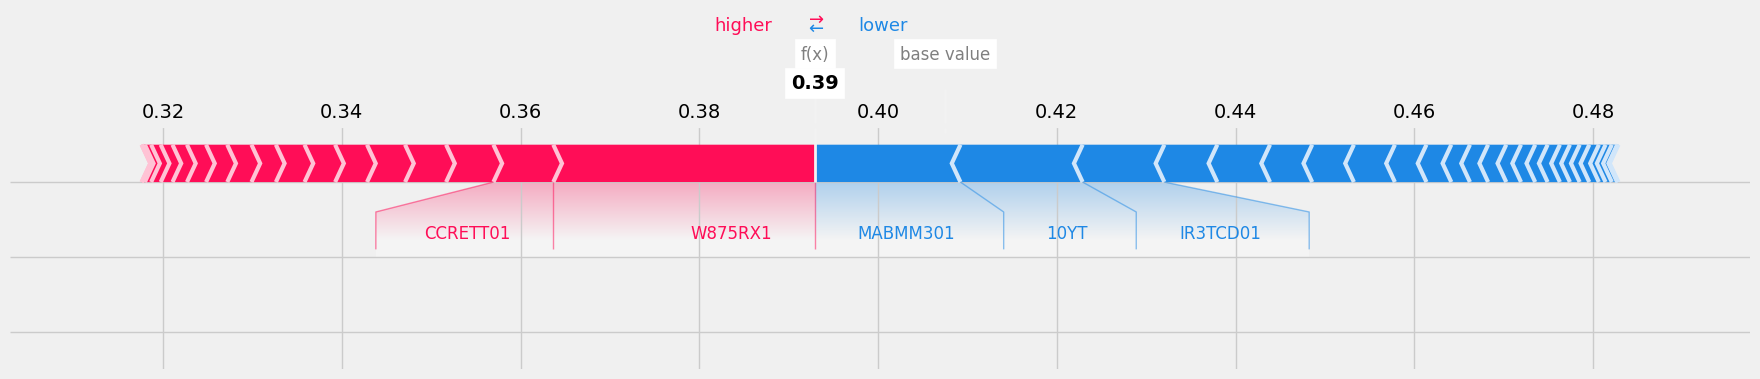

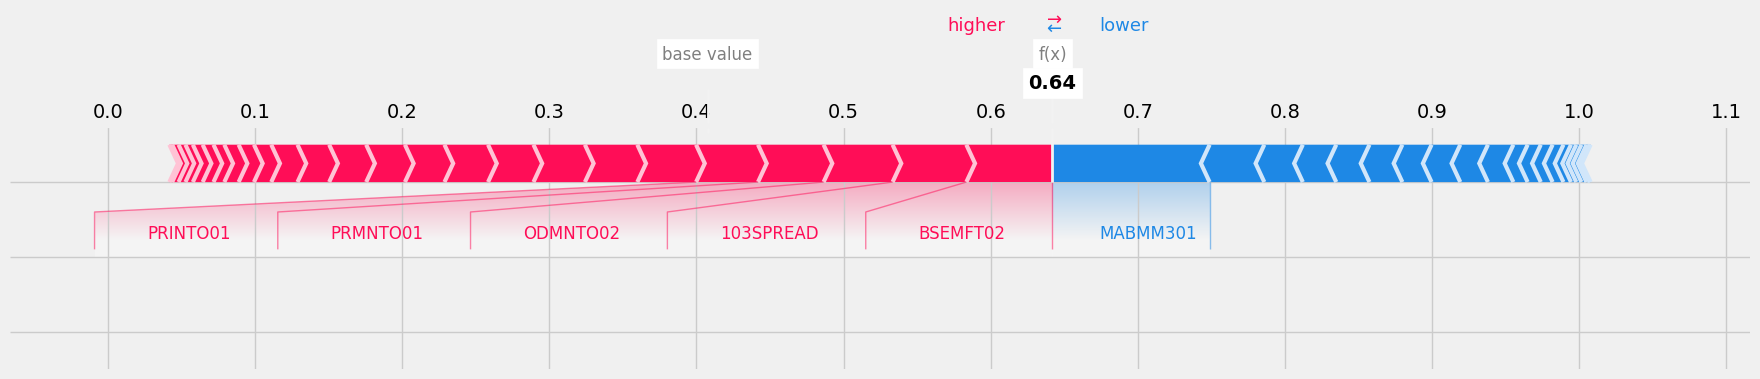

In [21]:
## ****** assign here! ***********//
label=1
version='test' ## 'train' or 'test'
t_list=[-2, -1]
##############################################################

if version=='train':
    values=values_train
else:
    values=values_test

for t in t_list:
    value_ft_t=np.sum(values[label][t], axis=0)
    shap.initjs()
    shap.force_plot(explainer.expected_value[label], value_ft_t, selected_features, matplotlib=True)

In [22]:
true_label=0
false_label=1

## calculate error time period list
err_idxs=np.argwhere((y_pred==false_label)&(y_test==true_label)).flatten() ## 1인데, 0으로 예측한 t지점들

## for each error time period, draw force_plot in terms of features
#value_ft=np.sum(values_test[label][t], axis=0)

for err_t in err_idxs:
    value_ft=np.sum(values_test[true_label][err_t], axis=0)
    shap.initjs()
    shap.force_plot(explainer.expected_value[true_label], value_ft, selected_features, matplotlib=True)

Output hidden; open in https://colab.research.google.com to view.

In [23]:
true_label=0
false_label=1

## calculate error time period list
ts_list=list(range(time_step))
err_idxs=np.argwhere((y_pred==false_label)&(y_test==true_label)).flatten()

## for each error time period, draw force_plot in terms of time steps
for err_t in err_idxs:
    value_ts=np.sum(values_test[true_label][err_t], axis=1)
    shap.initjs()
    shap.force_plot(explainer.expected_value[true_label], value_ts, ts_list, matplotlib=True)

Output hidden; open in https://colab.research.google.com to view.